In [1]:
import csv

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import torch
from tqdm import tqdm

from src import read_dicom, Detector, Siddon
from src.metrics import xcorr2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# DRR utility functions
volume, spacing = read_dicom("../data/cxr/")
isocenter = [0., 0., 0.]
siddon = Siddon(spacing, isocenter, volume, device)

def make_drr(theta, phi, gamma, bx, by, bz, sdr=200., height=100, delx=5e-2):
    """Detector parameters -> DRR"""
    detector = Detector(
        sdr    = sdr,
        theta  = theta,
        phi    = phi,
        gamma  = gamma,
        bx     = bx,
        by     = by,
        bz     = bz,
        device = device
    )
    source, rays = detector.make_xrays(height, height, delx, delx)
    drr = siddon.raytrace(source, rays)
    return drr, detector.angles, detector.translation

def plot(drr):
    plt.imshow(drr.detach().cpu(), cmap="gray")
    plt.show()
    
def corr(drr, est):
    x = xcorr2()
    loss = x(drr.expand(1, 1, -1, -1), est.expand(1, 1, -1, -1))
    return loss

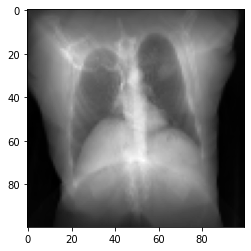

In [3]:
# Get the ground truth DRR
theta = torch.pi
phi = 0
gamma = torch.pi / 2
bx = 180
by = 180
bz = 166.25

drr, _, _ = make_drr(theta, phi, gamma, bx, by, bz)
plot(drr)

In [4]:
import time

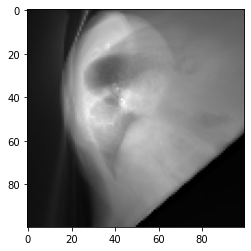

0 -16.452943132525853 27.876961476045942 -0.7356735381135563 -0.7715805598165164 -0.7032474175664447
Initial loss: 0.5538
0 -0.5921 0.7531 0.8004 0.716 -0.5207 16.276 -28.1979
25 -0.7242 0.8847 0.9434 0.92 -6.1772 14.7424 -25.8504
50 -0.7422 0.8825 0.9026 1.0307 -7.2171 12.6735 -23.5621
75 -0.7533 0.8799 0.8853 1.1416 -7.0372 11.1324 -23.0202


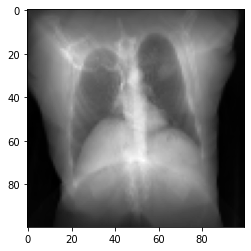

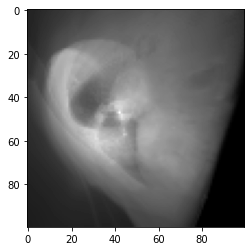

In [9]:
### Generate a random DRR
# x = np.random.uniform(-30., 31.)
x = 0
y = np.random.uniform(-30., 31.)
z = np.random.uniform(-30., 30.)
t = np.random.uniform(-np.pi/4, np.pi/4)
p = np.random.uniform(-np.pi/3, np.pi/3)
g = np.random.uniform(-np.pi/3, np.pi/3)
est, angles, trans = make_drr(theta+t, phi+p, gamma+g, bx+x, by+y, bz+z)
plot(est)
print(x, y, z, t, p, g)

# loss = torch.norm(drr - est, 2)
loss = -corr(drr, est)
print("Initial loss:", round(corr(drr, est).item(), 4))
loss.backward(retain_graph=True)

### Optimize it

# For neg NCC loss
alpha1 = 7.5e1  # Easy problems x=(-30,31)
# alpha1 = 3.5e2
alpha2 = 5.3e-2 # Easy problems
# alpha2 = 3e-1

t0 = time.time()
for i in range(100):
    x, y, z = trans - alpha1 * trans.grad
    t, p, g = angles - alpha2 * angles.grad
    x = x.item()
    y = y.item()
    z = z.item()
    t = t.item()
    p = p.item()
    g = g.item()

    est, angles, trans = make_drr(t, p, g, x, y, z)
    # loss = torch.norm(drr - est, 2)
    loss = -corr(drr, est)
    if i % 25 == 0:
        print(
            i, round(-corr(drr, est).item(), 4), 
            round(theta-t, 4), round(phi-p, 4), round(gamma-g, 4),
            round(bx-x,4), round(by-y, 4), round(bz-z,4)
        )
    if loss < -0.999:
        print(f"Converged in {i} iterations")
        print(
            round(theta-t, 4), round(phi-p, 4), round(gamma-g, 4),
            round(bx-x,4), round(by-y, 4), round(bz-z,4)
        )
        break
    loss.backward(retain_graph=True)
    # plot(est)
t1 = time.time()

plot(drr)
plot(est)

In [10]:
t1 - t0

2.919121503829956

In [11]:
def run_convergence_exp(filename, debug=False):

    # Initialize a random moving DRR
    x = np.random.uniform(-30., 31.)
    y = np.random.uniform(-30., 31.)
    z = np.random.uniform(-30., 30.)
    t = np.random.uniform(-np.pi/4, np.pi/4)
    p = np.random.uniform(-np.pi/3, np.pi/3)
    g = np.random.uniform(-np.pi/3, np.pi/3)
    est, angles, trans = make_drr(theta+t, phi+p, gamma+g, bx+x, by+y, bz+z)
    loss = -corr(drr, est)
    loss.backward(retain_graph=True)

    with open(filename, "w") as f:
        # Save the moving DRR's initial parameters
        f.write(f"# {theta+t},{phi+p},{gamma+g},{bx+x},{by+y},{bz+z}\n")

        # Start the training log
        writer = csv.writer(f, delimiter=",")
        writer.writerow(["itr", "loss", "delt", "detp", "delg", "delx", "dely", "delz"])
        writer.writerow([0, loss.item(), t, p, g, x, y, z])

        # Start the training loop
        for itr in range(1, 501):

            # Take a gradient step and make a new DRR
            x, y, z = trans - alpha1 * trans.grad
            t, p, g = angles - alpha2 * angles.grad
            x = x.item()
            y = y.item()
            z = z.item()
            t = t.item()
            p = p.item()
            g = g.item()
            est, angles, trans = make_drr(t, p, g, x, y, z)

            # Compute the loss
            loss = -corr(drr, est)
            loss.backward(retain_graph=True)

            # Write to CSV
            writer.writerow([itr, loss.item(), theta-t, phi-p, gamma-g, bx-x, by-y, bz-z])

            # Early stop condition
            if loss < -0.99:
                break

            if debug:
                if itr % 25 == 0:
                    print(loss.item())

In [6]:
for i in tqdm(range(100)):
    run_convergence_exp(filename=f"../results/grad_desc/{i}.csv")

100%|██████████████████████████████████████████████████████████████| 100/100 [10:00<00:00,  6.01s/it]


In [7]:
for i in tqdm(range(400)):
    run_convergence_exp(filename=f"../results/grad_desc/{100+i}.csv")

100%|██████████████████████████████████████████████████████████████| 400/400 [46:11<00:00,  6.93s/it]


In [12]:
for i in tqdm(range(500)):
    run_convergence_exp(filename=f"../results/grad_desc/{500+i}.csv")

100%|██████████████████████████████████████████████████████████████| 500/500 [56:54<00:00,  6.83s/it]
